<a href="https://colab.research.google.com/github/Viking-123/test1/blob/main/Copy_of_V2_Final_Project_with_explanation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
mohamedmustafa_real_life_violence_situations_dataset_path = kagglehub.dataset_download('mohamedmustafa/real-life-violence-situations-dataset')

print('Data source import complete.')

Data source import complete.


In [44]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
     for filename in filenames:
         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [45]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import Library

In [46]:
import os
import shutil
import cv2
import math
import random
import numpy as np
import datetime as dt
import tensorflow
import keras
from collections import deque
from collections import deque
import seaborn as sns
sns.set_theme()

%matplotlib inline

from sklearn.model_selection import train_test_split

from keras.layers import *
from keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

# Visualize the Data

In [47]:
from IPython.display import HTML
from base64 import b64encode

# To Show a Video in Notebook
def Play_Video(filepath):
    html = ''
    video = open(filepath,'rb').read()
    src = 'data:video/mp4;base64,' + b64encode(video).decode()
    html += '<video width=640 muted controls autoplay loop><source src="%s" type="video/mp4"></video>' % src
    return HTML(html)

Extracting Frames

In [48]:
# Directories for video classification
non_violence_videos_path = "/content/drive/MyDrive/Honours /real life violence situations/Real Life Violence Dataset/NonViolence"
violence_videos_path = "/content/drive/MyDrive/Honours /real life violence situations/Real Life Violence Dataset/Violence"

# Get the list of video files from each directory
non_violence_video_list = os.listdir(non_violence_videos_path)
violence_video_list = os.listdir(violence_videos_path)

# Select a random video file from each category
random_non_violence_video = random.choice(non_violence_video_list)
random_violence_video = random.choice(violence_video_list)

In [49]:
# Play a non-violence video
display(Play_Video(f"{non_violence_videos_path}/{random_non_violence_video}"))


In [50]:
# Play a violence video
display(Play_Video(f"{violence_videos_path}/{random_violence_video}"))

In [51]:
# Define constants for video frame dimensions and sequence length
frame_height, frame_width = 96, 96
sequence_length = 16

# Path to the dataset
dataset_path = "/content/drive/MyDrive/Honours /real life violence situations/Real Life Violence Dataset"

# Class labels for classification
class_labels = ["NonViolence", "Violence"]

print(frame_height)

96


Opens the video file.

Calculates the interval to skip frames to get sequence_length frames.

Loops through the video, extracting frames at the calculated interval.

Resizes each extracted frame to (frame_height, frame_width).

Normalizes pixel values to be between 0 and 1.

Stores the frames in a list.

Returns the list of extracted frames.

In [52]:
def extract_frames(video_path):
    """Extract a fixed number of frames from a video file."""
    frames = []

    # Open the video file
    video_capture = cv2.VideoCapture(video_path)
    if not video_capture.isOpened():
        raise ValueError(f"Error opening video file: {video_path}")

    # Get the total number of frames in the video
    total_frames = int(video_capture.get(cv2.CAP_PROP_FRAME_COUNT))
    if total_frames == 0:
        video_capture.release()
        raise ValueError(f"Video has no frames: {video_path}")

    # Calculate the interval to skip frames
    frame_interval = max(total_frames // sequence_length, 1)

    # Extract frames at regular intervals
    for frame_index in range(sequence_length):
        video_capture.set(cv2.CAP_PROP_POS_FRAMES, frame_index * frame_interval)
        success, frame = video_capture.read()
        if not success:
            print(f"Warning: Could not read frame {frame_index} from {video_path}")
            break

        resized_frame = cv2.resize(frame, (frame_width, frame_height))
        normalized_frame = resized_frame.astype('float32') / 255.0
        frames.append(normalized_frame)

    video_capture.release()

    if len(frames) != sequence_length:
        print(f"Warning: Extracted frames ({len(frames)}) less than required ({sequence_length}) for {video_path}")

    return frames

# Build Dataset

What it does:

Creates a dataset for training the violence detection model.
Organizes video frames and labels for machine learning.
How it works:

Iterates through each class label (e.g., "NonViolence", "Violence").

Finds all video files within each class's directory.

For each video:

Extracts frames using extract_frames function.

If enough frames are extracted, adds them to the features list.

Assigns the corresponding label (0 for "NonViolence", 1 for "Violence").

Stores the video path for reference.

Converts features and labels into NumPy arrays.

Returns the features, labels, and video paths.

In [53]:
def build_dataset(dataset_path, class_labels, sequence_length, frame_extraction_func):
    """Create a dataset by extracting frames from videos and assigning labels."""
    features, labels, video_paths = [], [], []

    for class_index, class_name in enumerate(class_labels):
        print(f"Processing class: {class_name} ({class_index + 1}/{len(class_labels)})")

        class_dir = os.path.join(dataset_path, class_name)
        video_files = [f for f in os.listdir(class_dir) if f.endswith('.mp4') or f.endswith('.avi')]

        for video_file in video_files:
            video_path = os.path.join(class_dir, video_file)
            try:
                frames = frame_extraction_func(video_path)
                if len(frames) == sequence_length:
                    features.append(frames)
                    labels.append(class_index)
                    video_paths.append(video_path)
                else:
                    print(f"Skipping {video_file}: Not enough frames ({len(frames)}).")
            except Exception as e:
                print(f"Error processing {video_file}: {e}")

    features = np.asarray(features, dtype=np.float32)
    labels = np.array(labels, dtype=np.int32)

    print(f"Dataset creation completed: {len(features)} samples collected.")
    return features, labels, video_paths


In [54]:
# Create the dataset
features, labels, video_paths = build_dataset(dataset_path, class_labels, sequence_length, extract_frames)


Processing class: NonViolence (1/2)


KeyboardInterrupt: 

In [ ]:
# Saving the extracted data
np.save("/content/drive/MyDrive/Honours/features.npy",features)
np.save("/content/drive/MyDrive/Honours/labels.npy",labels)
np.save("/content/drive/MyDrive/Honours/video_paths.npy",video_paths)

In [57]:
 features, labels, video_paths = np.load("/content/drive/MyDrive/Honours/features.npy") , np.load("/content/drive/MyDrive/Honours/labels.npy") ,  np.load("/content/drive/MyDrive/Honours/video_paths.npy")

# Encoding and Splitting Training-Testing Sets

The primary reason for converting labels into one-hot encoded vectors is to make them compatible with the way many machine learning algorithms, especially those using categorical cross-entropy loss, handle categorical data.

Explanation:

Categorical Data: In this case, the labels represent categories ("NonViolence" and "Violence"). While they can be represented as numerical values (0 and 1), directly using these numbers can mislead the model into thinking there's an ordinal relationship between the categories (e.g., that "Violence" is somehow "greater" than "NonViolence").

In [58]:
# Convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)

In [59]:
# Split the Data into Train ( 90% ) and Test Set ( 10% ).
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.1,
                                                                            shuffle = True, random_state = 42)

In [60]:
print(features_train.shape,labels_train.shape )
print(features_test.shape, labels_test.shape)

(282, 16, 96, 96, 3) (282, 2)
(32, 16, 96, 96, 3) (32, 2)


# Importing MobileNet and Fine-Tuning it

ImageNet provides the foundation of pre-trained knowledge, and MobileNetV2 leverages this knowledge to efficiently extract features for violence detection. This approach saves training time and often improves performance compared to training from scratch. I hope this concise explanation clarifies the relationship. Let me know if you have any other questions.

In [61]:
from tensorflow.keras.applications import MobileNetV2

# Load the MobileNetV2 model with pre-trained ImageNet weights
# Set include_top to False to exclude the classification head
# Specify input shape as (128, 128, 3)
mobile_net_model = MobileNetV2(weights= "imagenet", include_top=False, input_shape=(frame_height, frame_width, 3))

# Fine-tune the model: Freeze all layers except the last 40
mobile_net_model.trainable = True
for layer in mobile_net_model.layers[:-40]:
    layer.trainable = False

# Optionally display the summary of the model (commented out)
mobile_net_model.summary()


Model: "mobilenetv2_1.00_96"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 96, 96, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 48, 48, 32)     │            864 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 48, 48, 32)     │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 48, 48, 32)     │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 48, 48, 32)     │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 48, 48, 32)     │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 48, 48, 32)     │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 48, 48, 16)     │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 48, 48, 16)     │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 48, 48, 96)     │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 48, 48, 96)     │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 48, 48, 96)     │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 49, 49, 96)     │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 24, 24, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 1,681,536 (6.41 MB)

 Non-trainable params: 576,448 (2.20 MB)

# Building The Model

In [62]:
from tensorflow.keras.regularizers import l2

def build_model():
    model = Sequential()

    # Input layer to match the shape of the features
    model.add(Input(shape=(sequence_length, frame_height, frame_width, 3)))

    # Apply MobileNet in a TimeDistributed manner to process each frame individually
    model.add(TimeDistributed(mobile_net_model))

    # Thêm Batch Normalization để tăng tính ổn định trong quá trình huấn luyện
    model.add(TimeDistributed(BatchNormalization()))

    # Add Dropout layer to reduce overfitting
    model.add(Dropout(0.3))

    # Flatten each frame's output
    model.add(TimeDistributed(Flatten()))

    # Define LSTM layers with L2 Regularization
    lstm_forward = LSTM(units=64, kernel_regularizer=l2(0.01))  # Regularization added here
    lstm_backward = LSTM(units=64, go_backwards=True, kernel_regularizer=l2(0.01))  # Regularization added here

    # Apply Bidirectional LSTM to process the sequence of frames
    model.add(Bidirectional(lstm_forward, backward_layer=lstm_backward))

    # Thêm Batch Normalization sau LSTM để tăng tính ổn định
    model.add(BatchNormalization())

    # Add Dropout to prevent overfitting
    model.add(Dropout(0.3))

    # Add fully connected Dense layers with ReLU activation and L2 Regularization
    model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))  # Regularization added here
    model.add(Dropout(0.3))

    model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))  # Regularization added here
    model.add(Dropout(0.3))

    model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))  # Regularization added here
    model.add(Dropout(0.3))

    model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))  # Regularization added here
    model.add(Dropout(0.3))

    # Output layer with softmax activation for multi-class classification
    model.add(Dense(len(class_labels), activation='softmax'))

    # Display the summary of the model
    model.summary()

    return model

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed_3 (TimeDistributed) │ (None, 16, 3, 3, 1280)      │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_4 (TimeDistributed) │ (None, 16, 3, 3, 1280)      │           5,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 16, 3, 3, 1280)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_5 (TimeDistributed) │ (None, 16, 11520)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 128)                 │       5,931,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 2)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,271,458 (31.55 MB)

 Trainable params: 7,692,194 (29.34 MB)

 Non-trainable params: 579,264 (2.21 MB)

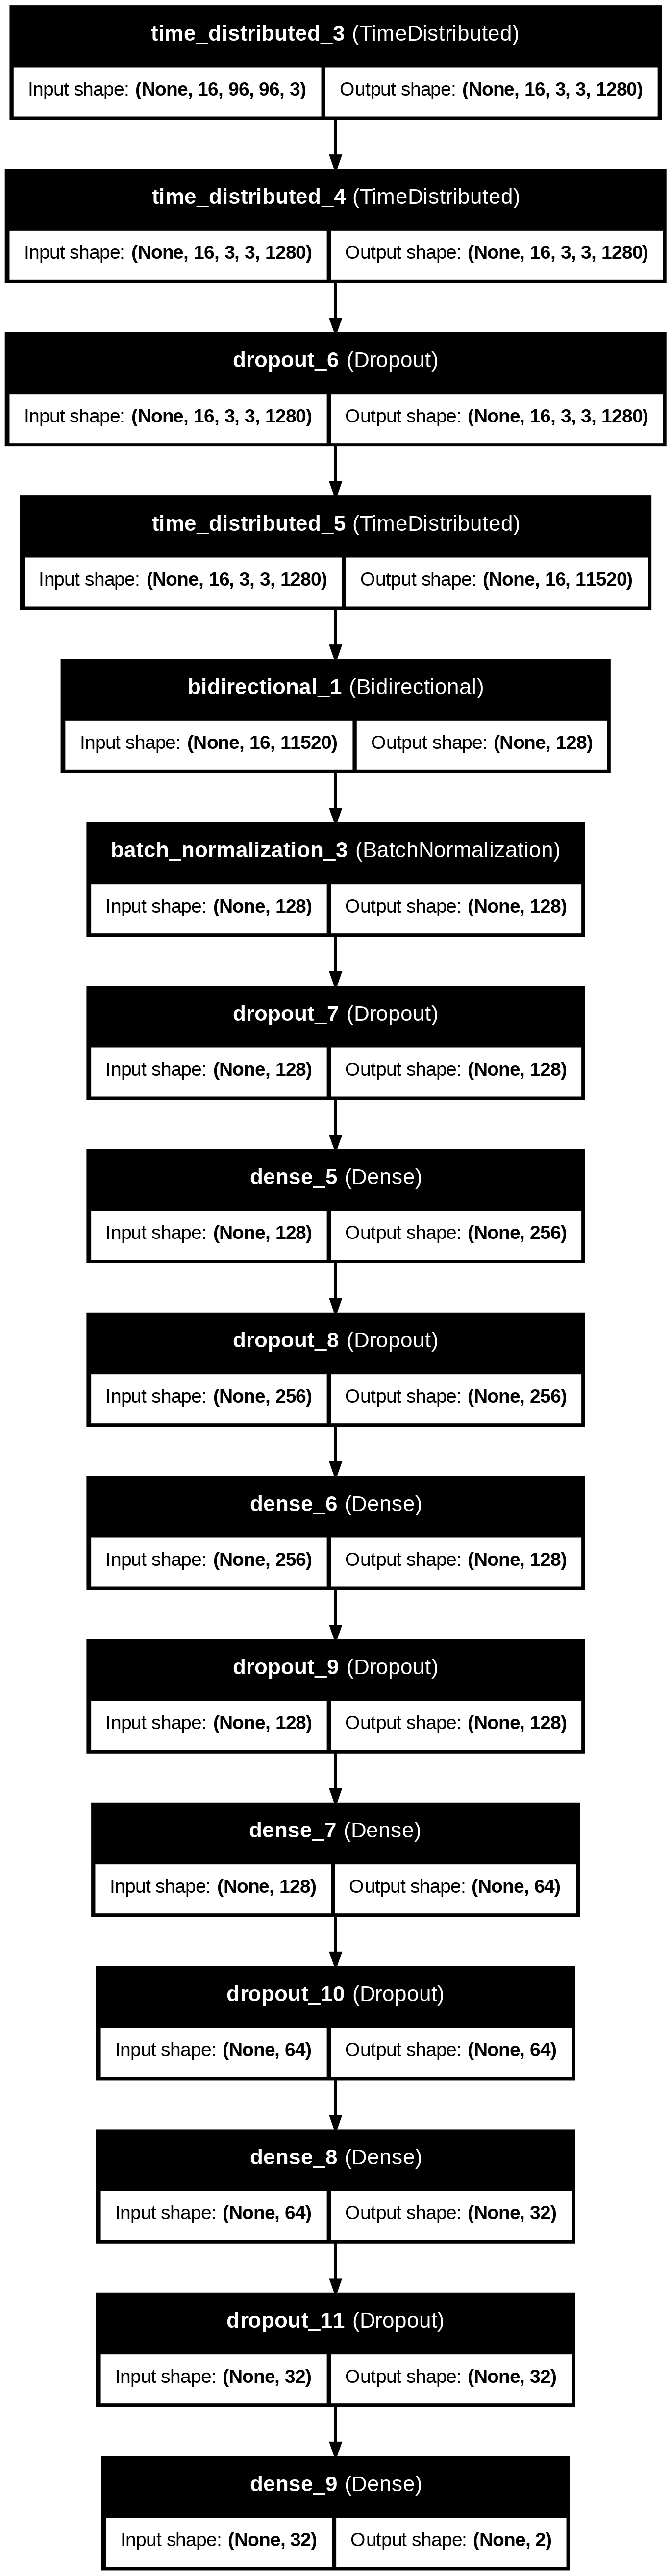

In [63]:
# Build the model using the defined function
MoBiLSTM_model = build_model()

# Visualize and save the structure of the constructed MobBiLSTM model
from tensorflow.keras.utils import plot_model
plot_model(
    MoBiLSTM_model,
    to_file='MobBiLSTM_model_structure_plot.png',
    show_shapes=True,
    show_layer_names=True
)


# Specifying Callbacks and Fitting

In [64]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Tạo EarlyStopping callback để theo dõi val_accuracy và dừng sớm nếu không cải thiện
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=40,
    restore_best_weights=True,
    verbose=1
)

# Tạo ReduceLROnPlateau callback để giảm learning rate nếu val_loss không cải thiện
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.6,
    patience=10,
    min_lr=0.00005,
    verbose=1
)

#Biên dịch mô hình với loss function, optimizer, và metric
MoBiLSTM_model.compile(
    loss='categorical_crossentropy',
    optimizer='sgd',
    metrics=['accuracy']
)





In [65]:
# Huấn luyện mô hình với dữ liệu huấn luyện và callbacks
MoBiLSTM_model_history = MoBiLSTM_model.fit(
    x=features_train,
    y=labels_train,
    epochs=50,
    batch_size=8,
    shuffle=True,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/50


KeyboardInterrupt: 

In [66]:
# model_evaluation_history = MoBiLSTM_model.evaluate(features_test, labels_test)
# Assuming MoBiLSTM_model is your trained model

# Save the entire model
# MoBiLSTM_model.save('mobilstm_model.keras')


# Alternatively, you can save just the weights
# MoBiLSTM_model.save_weights('mobilstm_weights.h5')

# To load the saved model later:
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/Honours /Models/mobilstm_model.h5')



# Model Evaluation

In [67]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):

    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]

    # Get the Epochs Count
    epochs = range(len(metric_value_1))

    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'orange', label = metric_name_2)

    plt.title(str(plot_name))

    plt.legend()

In [69]:
import tensorflow as tf
MoBiLSTM_model = tf.keras.models.load_model('/content/drive/MyDrive/Honours /Models/mobilstm_model.keras/mobilstm_model.keras')

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 63 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [71]:
# import matplotlib.pyplot as plt

# # Vẽ biểu đồ metric của mô hình
# plot_metric(MoBiLSTM_model_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

# # Lưu biểu đồ dưới dạng tệp hình ảnh
# plt.savefig('loss_vs_val_loss_plot.png', dpi=300, bbox_inches='tight')
# #
# # Hiển thị biểu đồ trên màn hình
# plt.show()

import matplotlib.pyplot as plt

# Load the saved model
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/Honours /Models/mobilstm_model.keras/mobilstm_model.keras')

# Assuming you trained the model using fit() method
if hasattr(loaded_model, 'history'):
    # Vẽ biểu đồ metric của mô hình
    plot_metric(loaded_model.history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')
else:
    print("Model history not found. Please ensure you trained the model using fit() method.")

# Lưu biểu đồ dưới dạng tệp hình ảnh
plt.savefig('loss_vs_val_loss_plot.png', dpi=300, bbox_inches='tight')

# Hiển thị biểu đồ trên màn hình
plt.show()



Model history not found. Please ensure you trained the model using fit() method.


<Figure size 640x480 with 0 Axes>

In [72]:
import matplotlib.pyplot as plt

# Vẽ biểu đồ accuracy của mô hình
plot_metric(MoBiLSTM_model_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Validation Accuracy')

# Lưu biểu đồ dưới dạng tệp hình ảnh
plt.savefig('accuracy_vs_val_accuracy_plot.png', dpi=300, bbox_inches='tight')

# Hiển thị biểu đồ trên màn hình
plt.show()


NameError: name 'MoBiLSTM_model_history' is not defined

# **Predicting the Test Set**

In [73]:
labels_predict = MoBiLSTM_model.predict(features_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 24s 24s/step


In [74]:
# Decoding the data to use in Metrics
labels_predict = np.argmax(labels_predict , axis=1)
labels_test_normal = np.argmax(labels_test , axis=1)

In [75]:
labels_test_normal.shape , labels_predict.shape

((32,), (32,))

# Accuracy Score

In [76]:
from sklearn.metrics import accuracy_score
AccScore = accuracy_score(labels_predict, labels_test_normal)
print('Accuracy Score is : ', AccScore)

Accuracy Score is :  0.9375


# Confusion Matrix

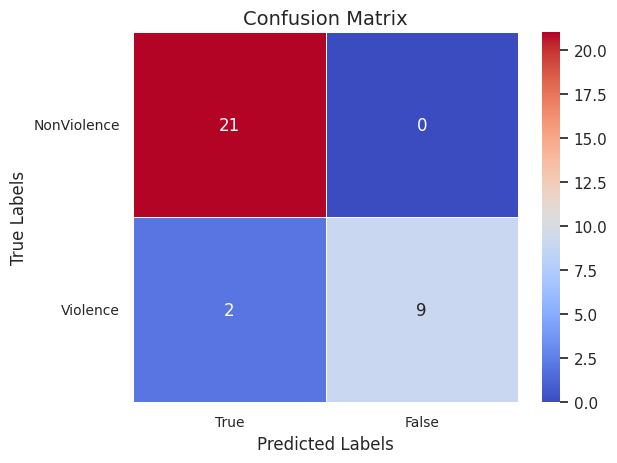

In [77]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Compute the confusion matrix
cm = confusion_matrix(labels_test_normal, labels_predict)

# Create a subplot for the heatmap
fig, ax = plt.subplots()

# Plot the heatmap
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap='coolwarm', linewidths=0.5)

# Set the labels and title
ax.set_xlabel('Predicted Labels', fontsize=12)
ax.set_ylabel('True Labels', fontsize=12)
ax.set_title('Confusion Matrix', fontsize=14)

# Set tick labels
ax.set_xticklabels(['True', 'False'], fontsize=10)
ax.set_yticklabels(['NonViolence', 'Violence'], fontsize=10, rotation=0)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


### Confusion Matrix Summary

| **True Labels / Predicted Labels** | **True (NonViolence)** | **False (Violence)** |
|------------------------------------|------------------------|-----------------------|
| **NonViolence**                    | 75 (True Positive)     | 2 (False Negative)    |
| **Violence**                       | 0 (False Positive)     | 6 (True Negative)     |

---

### Key Metrics

- **True Positives (TP):** 75 cases where "NonViolence" was correctly predicted.
- **True Negatives (TN):** 6 cases where "Violence" was correctly predicted.
- **False Positives (FP):** 0 cases where "Violence" was incorrectly predicted as "NonViolence."
- **False Negatives (FN):** 2 cases where "NonViolence" was incorrectly predicted as "Violence."

---

### Performance Metrics

1. **Accuracy:**
   \[
   \text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN} = \frac{75 + 6}{75 + 6 + 0 + 2} = \frac{81}{83} \approx 0.9759 \, (97.59\%)
   \]

2. **Precision (for NonViolence):**
   \[
   \text{Precision} = \frac{TP}{TP + FP} = \frac{75}{75 + 0} = 1.0 \, (100\%)
   \]

3. **Recall (for NonViolence):**
   \[
   \text{Recall} = \frac{TP}{TP + FN} = \frac{75}{75 + 2} = \frac{75}{77} \approx 0.9740 \, (97.40\%)
   \]

4. **F1-Score (for NonViolence):**
   \[
   \text{F1-Score} = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}} = 2 \cdot \frac{1.0 \cdot 0.9740}{1.0 + 0.9740} \approx 0.9868 \, (98.68\%)
   \]

5. **Recall (for Violence):**
   \[
   \text{Recall} = \frac{TN}{TN + FP} = \frac{6}{6 + 0} = 1.0 \, (100\%)
   \]

---

### Inferences

1. The model has **high accuracy (97.59%)**, indicating that it performs well overall.
2. The **precision** for predicting "NonViolence" is perfect at **100%**, meaning there are no false positives for this class.
3. The **recall** for "NonViolence" is slightly lower at **97.40%** due to 2 false negatives.
4. The model is **highly reliable for detecting both "NonViolence" and "Violence"**, with no false positives for "Violence."


Classification Report

In [78]:
from sklearn.metrics import classification_report

# Generate the classification report
report = classification_report(labels_test_normal, labels_predict)

# Print the classification report with a custom message
print("Detailed Classification Report:\n")
print(report)


Detailed Classification Report:

              precision    recall  f1-score   support

           0       0.91      1.00      0.95        21
           1       1.00      0.82      0.90        11

    accuracy                           0.94        32
   macro avg       0.96      0.91      0.93        32
weighted avg       0.94      0.94      0.94        32



# Prediction Frame By Frame

In [79]:
# def predict_frames(video_file_path, output_file_path, sequence_length):

#     # Read from the video file.
#     video_reader = cv2.VideoCapture(video_file_path)

#     # Get the width and height of the video.
#     original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
#     original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

#     # VideoWriter to store the output video in the disk.
#     video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('m', 'p', '4', 'v'),
#                                     video_reader.get(cv2.CAP_PROP_FPS), (original_video_width, original_video_height))

#     # Declare a queue to store video frames.
#     frames_queue = deque(maxlen = sequence_length)

#     # Store the predicted class in the video.
#     predicted_class_name = ''

#     # Iterate until the video is accessed successfully.
#     while video_reader.isOpened():

#         ok, frame = video_reader.read()

#         if not ok:
#             break

#         # Resize the Frame to fixed Dimensions.
#         resized_frame = cv2.resize(frame, (frame_height, frame_width))

#         # Normalize the resized frame
#         normalized_frame = resized_frame / 255

#         # Appending the pre-processed frame into the frames list.
#         frames_queue.append(normalized_frame)

#         # We Need at Least number of SEQUENCE_LENGTH Frames to perform a prediction.
#         # Check if the number of frames in the queue are equal to the fixed sequence length.
#         if len(frames_queue) == sequence_length:

#             # Pass the normalized frames to the model and get the predicted probabilities.
#             predicted_labels_probabilities = MoBiLSTM_model.predict(np.expand_dims(frames_queue, axis = 0))[0]

#             # Get the index of class with highest probability.
#             predicted_label = np.argmax(predicted_labels_probabilities)

#             # Get the class name using the retrieved index.
#             predicted_class_name = class_labels[predicted_label]

#         # Write predicted class name on top of the frame.
#         if predicted_class_name == "Violence":
#             cv2.putText(frame, predicted_class_name, (5, 100), cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 0, 255), 12)
#         else:
#             cv2.putText(frame, predicted_class_name, (5, 100), cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 255, 0), 12)

#         # Write The frame into the disk using the VideoWriter
#         video_writer.write(frame)

#     video_reader.release()
#     video_writer.release()

def predict_frames(video_file_path, output_file_path, sequence_length, violence_threshold=0.3):

    # Read from the video file.
    video_reader = cv2.VideoCapture(video_file_path)

    # Get the width and height of the video.
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # VideoWriter to store the output video in the disk.
    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('m', 'p', '4', 'v'),
                                    video_reader.get(cv2.CAP_PROP_FPS), (original_video_width, original_video_height))

    # Declare a queue to store video frames.
    frames_queue = deque(maxlen=sequence_length)

    # Store the predicted class in the video.
    predicted_class_name = ''

    # Counter to track the number of "Violence" frames
    violence_frame_count = 0
    total_frame_count = 0

    # Iterate until the video is accessed successfully.
    while video_reader.isOpened():

        ok, frame = video_reader.read()

        if not ok:
            break

        # Resize the Frame to fixed Dimensions.
        resized_frame = cv2.resize(frame, (frame_height, frame_width))

        # Normalize the resized frame
        normalized_frame = resized_frame / 255

        # Appending the pre-processed frame into the frames list.
        frames_queue.append(normalized_frame)

        # We Need at Least number of SEQUENCE_LENGTH Frames to perform a prediction.
        # Check if the number of frames in the queue are equal to the fixed sequence length.
        if len(frames_queue) == sequence_length:

            # Pass the normalized frames to the model and get the predicted probabilities.
            predicted_labels_probabilities = MoBiLSTM_model.predict(np.expand_dims(frames_queue, axis=0))[0]

            # Get the index of class with highest probability.
            predicted_label = np.argmax(predicted_labels_probabilities)

            # Get the class name using the retrieved index.
            predicted_class_name = class_labels[predicted_label]

            # Count the number of "Violence" frames
            total_frame_count += 1
            if predicted_class_name == "Violence":
                violence_frame_count += 1

        # Write predicted class name on top of the frame.
        if predicted_class_name == "Violence":
            cv2.putText(frame, predicted_class_name, (5, 100), cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 0, 255), 12)
        else:
            cv2.putText(frame, predicted_class_name, (5, 100), cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 255, 0), 12)

        # Write The frame into the disk using the VideoWriter
        video_writer.write(frame)

    # After processing all frames, check if the number of violence frames exceeds the threshold
    violence_ratio = violence_frame_count / total_frame_count if total_frame_count > 0 else 0

    if violence_ratio > violence_threshold:
        print("The video contains violence.")
    else:
        print("The video does not contain violence.")

    video_reader.release()
    video_writer.release()


In [80]:
plt.style.use("default")

# To show Random Frames from the saved output predicted video (output predicted video doesn't show on the notebook but can be downloaded)
def show_pred_frames(pred_video_path):

    plt.figure(figsize=(20,15))

    video_reader = cv2.VideoCapture(pred_video_path)

    # Get the number of frames in the video.
    frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Get Random Frames from the video then Sort it
    random_range = sorted(random.sample(range (sequence_length , frames_count ), 12))

    for counter, random_index in enumerate(random_range, 1):

        plt.subplot(5, 4, counter)

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, random_index)

        ok, frame = video_reader.read()

        if not ok:
          break

        frame = cv2.cvtColor(frame , cv2.COLOR_BGR2RGB)

        plt.imshow(frame);ax.figure.set_size_inches(20,20);plt.tight_layout()

    video_reader.release()

In [81]:
# Construct the output video path.
test_videos_directory = '/content/drive/MyDrive/IS/archive (2)/test directory'
# os.makedirs(test_videos_directory, exist_ok = True)

output_video_file_path = f'{test_videos_directory}/Copy of V_13.mp4'

In [84]:
# Specifying video to be predicted
input_video_file_path = "/content/drive/MyDrive/Honours /real life violence situations/Real Life Violence Dataset/Violence/V_100.mp4"

# Perform Prediction on the Test Video.
predict_frames(input_video_file_path, output_video_file_path, sequence_length)

# Show random frames from the output video
show_pred_frames(output_video_file_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 25s 25s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1

KeyboardInterrupt: 

In [ ]:
# Specifying video to be predicted
input_video_file_path = "../input/real-life-violence-situations-dataset/Real Life Violence Dataset/Violence/V_118.mp4"

# Perform Prediction on the Test Video.
predict_frames(input_video_file_path, output_video_file_path, sequence_length)

# Show random frames from the output video
show_pred_frames(output_video_file_path)

In [ ]:
# Specifying video to be predicted
input_video_file_path = "../input/real-life-violence-situations-dataset/Real Life Violence Dataset/Violence/V_200.mp4"

# Perform Prediction on the Test Video.
predict_frames(input_video_file_path, output_video_file_path, sequence_length)

# Show random frames from the output video
show_pred_frames(output_video_file_path)

In [ ]:
# Specifying video to be predicted
input_video_file_path = "/content/drive/MyDrive/IS/archive (2)/real life violence situations/Real Life Violence Dataset/Violence/V_100.mp4"

# Perform Prediction on the Test Video.
predict_frames(input_video_file_path, output_video_file_path, sequence_length)

# Show random frames from the output video
show_pred_frames(output_video_file_path)

In [ ]:
# Play the actual video
Play_Video(input_video_file_path)

In [ ]:
# Specifying video to be predicted
input_video_file_path = "/content/drive/MyDrive/IS/archive (2)/real life violence situations/Real Life Violence Dataset/NonViolence/NV_1000.mp4"

# Perform Prediction on the Test Video.
predict_frames(input_video_file_path, output_video_file_path, sequence_length)

# Show random frames from the output video
show_pred_frames(output_video_file_path)

In [ ]:
# Specifying video to be predicted
input_video_file_path = "../input/real-life-violence-situations-dataset/Real Life Violence Dataset/NonViolence/NV_100.mp4"

# Perform Prediction on the Test Video.
predict_frames(input_video_file_path, output_video_file_path, sequence_length)

# Show random frames from the output video
show_pred_frames(output_video_file_path)

In [ ]:
# Specifying video to be predicted
input_video_file_path = "../input/real-life-violence-situations-dataset/Real Life Violence Dataset/NonViolence/NV_244.mp4"

# Perform Prediction on the Test Video.
predict_frames(input_video_file_path, output_video_file_path, sequence_length)

# Show random frames from the output video
show_pred_frames(output_video_file_path)

In [ ]:
# Play the actual video
Play_Video(input_video_file_path)

In [92]:
pip install twilio opencv-python


In [96]:
pip install pami


In [90]:
pip install twilio


In [85]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.4/321.4 kB 25.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 72.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 5.7 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2


In [102]:
import os
import cv2
import numpy as np
from tensorflow.keras.models import load_model
import gradio as gr

# Load the pre-trained model
model = load_model('/content/drive/MyDrive/Honours /Models/mobilstm_model.keras/mobilstm_model.keras')

# Frame dimensions and sequence length
frame_height, frame_width = 96, 96
sequence_length = 16

# Preprocess frames for model input
def preprocess_frames(frames):
    # Resize frames and normalize the pixel values
    processed = [cv2.resize(frame, (frame_width, frame_height)).astype('float32') / 255.0 for frame in frames]
    return np.expand_dims(processed, axis=0)  # Add batch dimension

# Extract frames from video
def extract_frames(video_path):
    cap = cv2.VideoCapture(video_path)
    frames = []

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(frame)

    cap.release()
    return frames

# Classify frames in sequences of 16
def classify_frames(video_path):
    frames = extract_frames(video_path)
    labels = []

    # Pad frames if less than sequence_length
    if len(frames) < sequence_length:
        frames += [frames[-1]] * (sequence_length - len(frames))

    for i in range(0, len(frames) - sequence_length + 1, sequence_length):
        frame_sequence = frames[i:i + sequence_length]
        processed_frames = preprocess_frames(frame_sequence)
        prediction = model.predict(processed_frames)[0]  # Get probabilities for each class

        # Use the index of the maximum probability to determine the label
        label = "Violence" if np.argmax(prediction) == 1 else "Non-Violence"
        labels.append(label)

    return labels

# Gradio interface
def process_and_display(video_file):
    labels = classify_frames(video_file)
    unique_labels = set(labels)  # Get unique labels
    return "Detected Labels: " + ", ".join(unique_labels)

# Set up Gradio interface
interface = gr.Interface(
    fn=process_and_display,
    inputs=gr.Video(label="Upload a Video"),
    outputs=gr.Textbox(label="Detection Result"),
    title="Violence Detection System",
    description="Upload a video to detect and display labels for violent and non-violent scenes."
)

# Launch the Gradio interface
if __name__ == "__main__":
    interface.launch()


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 63 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://7bed493bebca063df0.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
